# Investigating Bias in MLE Applied to GLMs

In this notebook, we will explore various factors affecting the quality of MLE estimates of GLM parameters. Initial investigation suggests that *at least* 3 factors play a major role:
1. Number of observations (n):

    It appears that, as expected, increasing n leads to better approximation to true betas (and standard error estimates converge on CRLB?)
    
    
2. Number of predictors (p):

    Increasing the number of predictors appears to increase bias and standard error estimates become far too small (i.e. percent true betas captured in 95% CI is well below 95%)
    
    
3. Spread of Betas:

    Larger range in value of parameters/betas appears to increase bias and standard error estimates become far too small. **Additionally, wider beta range appears to harm convergence of optimization algorithms**
    
Working Hypothesis is that much of this trouble stems from the link function (e.g. the squishing from the sigmoid at the boundaries). We will need to look at MLE for regular OLS for baseline, and at least one more link function would be helpful.

## Section 1 - Imports and Preliminaries

Importing required packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random

## Section 2 - Functions to Generate Data and Betas

### Function for Generating Standard Normal I.I.D. Predictors

For now, we restrict our attention to predictors whose values are all drawn from a standard normal distribution N(0,1). We may come back later and look at variations in predictor distributions and/or predictor types such as count or nominal.

**NOTE: The seeds have been turned off to allow distribution of predictors to vary from simulation to simulation**

In [26]:
def generateNormalVariables(n, p):

    X = {} # initialize dictionary to hold values

    for j in range(p):
        #np.random.seed(seed = j)   #seed for distribution
        #random.seed(j)   #seed for random number generator
        X[j] = np.random.normal(0, 1, n)
    return X

(array([ 14.,  51.,  99., 173., 214., 192., 139.,  84.,  28.,   6.]),
 array([-2.69691458, -2.13431164, -1.57170869, -1.00910575, -0.44650281,
         0.11610013,  0.67870307,  1.24130601,  1.80390895,  2.36651189,
         2.92911484]),
 <a list of 10 Patch objects>)

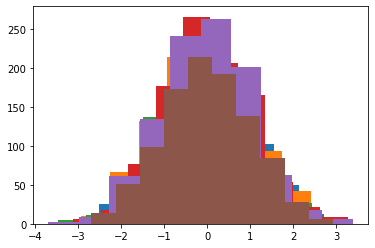

In [27]:
# Visualizing distribution of a few variables from generateNormalVariables (density plots would be better)
var_dict = generateNormalVariables(1000,100)
plt.hist(var_dict[0])
plt.hist(var_dict[1])
plt.hist(var_dict[4])
plt.hist(var_dict[3])
plt.hist(var_dict[2])
plt.hist(var_dict[5])

### Function for Generating Data

Previously, we had this function separate since we were also generating other variable types. Now, it is a tad superfluous. Whatever. Now, it just generates a column of 1's for the model intercept and then the predictors using the previously defined function - generateNormalVariables - and concatenates them. It returns a dataframe of, well, data.

In [28]:
def generateX(n,p):
    
    # Initialize dataframe with an intercept column
    intercept = np.repeat(1,n) # Create n 1's for intercept column
    X = pd.DataFrame(intercept.reshape(n,1))
    
    # Generate data
    if p != 0:
        Xnorm = generateNormalVariables(n, p)
        Xnorm = pd.DataFrame.from_dict(Xnorm)
        X = pd.concat([X, Xnorm],ignore_index=True,axis=1)
    
    return X

In [29]:
generateX(10,2)

,0,1,2
0,1,-0.051470,-2.260216
1,1,-0.386099,0.488257
2,1,0.267836,-1.275648
3,1,2.012989,0.130105
4,1,0.445633,-1.117854
5,1,0.645552,0.515510
6,1,0.753388,0.784733
7,1,-2.050559,0.256864
8,1,-0.394984,0.604954
9,1,-0.307340,0.360270


### Function for Generating Betas

The following function randomly generates the betas for the predictors. For now, these are drawn from a normal distribution with mean mu and standard deviation stdev - N(mu,stdev). We may want to look at other generating distributions, particularly ones where the data doesn't clump near the center like noncentral poisson or uniform. Initial investigations suggest the distribution shape doesn't make a difference - only the magnitude of the betas, but this is not yet conclusive.

**Note: Random seed is turned off here, too**

In [59]:
def generateRandomBeta(q, mu, stdev):
    beta = {}
    for j in range(q):
        #random.seed(j)#seed for random number generator
        beta[j] = np.random.normal(mu,stdev)
        #beta[j] = np.random.poisson(stdev)-3 # Checking to see what happens when betas come from noncentral poisson
    
    beta = pd.DataFrame(list(beta.items()))
    beta = beta.drop([0],axis=1)
    
    return beta

### Function for Generating Response Variable

After defining the sigmoid function, the next function generates the response variable depending on the link function used.

**Note (Once again): Random seed is turned off here, too**

In [60]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [61]:
def generateResponseVariable(X, beta, dist):
    
    beta = np.squeeze(beta)
    
    if dist == 'bernoulli':
        meanValues = sigmoid(X.dot(beta)) 
    elif dist == 'poisson':
        meanValues = np.exp(X.dot(beta))
    elif dist == 'exponential':
        meanValues = 1/(X.dot(beta))
    else:
        print('please spell check distribution name, all lowercase: bernoulli, poisson or exponential')
        
    y = []
    
    #np.random.seed(123)
    for eachMean in np.squeeze(meanValues.values):
        if dist == 'bernoulli':
            randomPrediction = np.random.binomial(1,eachMean)
        elif dist == 'poisson':
            randomPrediction = np.random.poisson(eachMean)
        elif dist == 'exponential':
            randomPrediction = np.random.exponential(eachMean)
        y.append(randomPrediction)
        #print(randomPrediction, eachMean)
    
    return meanValues, y

### Putting it All Together: Function to Generate Everything (Using Previously Defined Functions)

In [62]:
def generateData(dist, n, p, mu, stdev):
    
    # Generate Data
    X = generateX(n=n, p=p)

    # Generate Betas
    q = X.shape[1]
    beta = generateRandomBeta(q=q, mu=mu, stdev=stdev)

    # Generate Response Variable (and associated means - what goes into the link fn)
    means, y = generateResponseVariable(X=X, beta=beta, dist=dist) ### dist means pass distribution name as string
    
    # Make sure we return numpy arrays (easier to work with later and all names are useless here anyway)
    beta = np.squeeze(np.array(beta))
    X = np.array(X)
    y = np.array(y)    
    
    return X, beta, y, means

# Section 3: Logistic Regression Single Run Testbed

In [81]:
# Hyperparameters
n = 4000
p = 200 
mu = 1.0
stdev = 0.1

# Generate Data
X, b, y, means = generateData(dist = 'bernoulli', 
                              n = n, 
                              p = p, 
                              mu = mu,
                              stdev = stdev)
#print(b)

In [82]:
from statsmodels.discrete.discrete_model import Logit
 
model = Logit(y, X)
 
result = model.fit()

print("True Betas:      "+str(np.squeeze(b)) )
print("Estimated Betas: " + str(result.params) )
print("Standard Errors: " + str(result.bse) )

Optimization terminated successfully.
         Current function value: 0.055541
         Iterations 13
True Betas:      [0.95257954 0.98563797 1.09215773 1.006773   1.05820806 0.78640735
 1.04854603 0.94306317 1.0411904  0.91519731 1.14454616 1.15936274
 0.97280103 1.02481654 1.04646325 1.03780234 0.92525336 0.989617
 0.99730332 0.98020744 1.15792087 0.94465762 1.02492397 1.10318302
 1.1381374  0.89992783 0.96568512 1.08773051 1.06614204 0.87633575
 0.91189005 1.06095234 0.86281727 1.11986788 1.0077629  0.96921821
 0.97757767 0.82079745 1.08029205 1.01550205 1.23659542 1.03355603
 0.89710329 1.26400177 1.03944638 0.9088074  0.88846438 1.10182712
 1.05110803 1.01219934 1.06416796 1.05249659 0.94334048 0.99113155
 0.86175032 1.04392437 1.04615682 0.96600786 0.88995388 0.9123313
 1.07574335 1.06265643 0.83893879 1.0593103  0.92131387 1.18473899
 1.05093823 1.0783749  1.13327492 0.99456207 0.98258097 0.99234031
 0.94726291 1.0763046  0.8894681  1.14927002 1.10181533 0.9301312
 0.90851989 0

In [83]:
tb = np.squeeze(b)
est_betas_ub = result.params + 2*result.bse
est_betas_lb = result.params - 2*result.bse
captured = np.where((tb<=est_betas_ub)&(tb>=est_betas_lb),1,0)
print("Proportion of Betas within 2SE of True Value: "+str(sum(captured)/len(captured)))
print("")
diff = (result.params - np.squeeze(b))

Proportion of Betas within 2SE of True Value: 0.004975124378109453



RMSE:                                         0.9033756280074826
Average Standard Error:                       0.2285558741111323


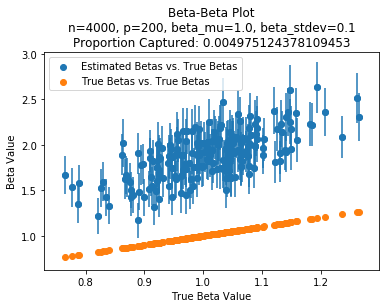

In [87]:
print("RMSE:                                         "+str(np.sqrt(np.mean(diff*diff))))
print("Average Standard Error:                       "+str(np.mean(result.bse)))
plt.scatter(np.squeeze(b),result.params, label="Estimated Betas vs. True Betas")
plt.errorbar(np.squeeze(b),result.params,yerr=result.bse, fmt='o')
plt.scatter(np.squeeze(b),np.squeeze(b), label="True Betas vs. True Betas")
#plt.ylim(-7.03,7.03)
#plt.xlim(-7.03,7.03)
plt.xlabel('True Beta Value')
plt.ylabel('Beta Value')
plt.title('Beta-Beta Plot\nn='+str(n)+', p='+str(p)+', beta_mu='+str(mu)+', beta_stdev='+str(stdev)+'\nProportion Captured: '+str(sum(captured)/len(captured)))
plt.legend()
plt.show()

In [203]:
#plt.hist(result.params, bins=100)
#plt.hist(b, bins=100)
#plt.xlim(-5,5)
#plt.hist(abs(result.params - np.squeeze(b)), bins=1000)
#plt.xlim(0,3)
#print(np.std(abs(result.params - np.squeeze(b))))
#print(np.mean(result.bse))

In [166]:
#plt.hist(result.bse, bins=1000)
#plt.xlim(0,3)

In [ ]:
# Hyperparameters
n = 4000
p = 200 
mu = 1.0
stdev = 0.1

# Generate Data
X, b, y, means = generateData(dist = 'bernoulli', 
                              n = n, 
                              p = p, 
                              mu = mu,
                              stdev = stdev)
model = Logit(y, X)
 
result = model.fit()

# Working out NR Optimization for Bernoulli

In [419]:
def Bernoulli_LL_Derivatives(betas, X, y):
    # NOTE: assumes betas, X, and y are all numpy arrays
    # Need betas to be 1-D vector; shape (k,) not (k,1)
    betas = np.squeeze(betas)
    
    # Gradient calculation
    grad = np.matmul(X.T, y) - np.matmul(X.T, sigmoid(np.matmul(X,betas)))
    
    # PREVIOUS HESSIAN CODE - IGNORE (KEPT B/C STRUCTURE MAY STILL BE USEFUL IDK...)
    # Hessian calculation (not sure how to vectorize this one. If anyone knows how Python does this
    # for covariance matrix calculations, I think we could code butcher it to work here)
    #hess = []
    #for i in range(len(b)):
    #    hess_row = []
    #    for j in range(len(b)):
    #        xixj = np.matmul(X[:,i].T, X[:,j])
    #        other = sigmoid(np.squeeze(np.matmul(X,betas)))*sigmoid(-np.squeeze(np.matmul(X,betas)))
    #        hess_row.append(-np.sum(xixj*other))
    #    hess.append(hess_row)
    #hess = np.array(hess) # convert to numpy array
    
    # THE FOLLOWING WORKS, BUT MAKING IMPROVED VERSION BELOW BY REMOVING THE INNER OBSERVATION LOOP
    ## Hessian calculation
    #hess = []
    #for i in range(len(b)):
    #    hess_row = []
    #    for j in range(len(b)):
    #        cell_value = 0
    #        for obs in range(X.shape[0]):
    #            xixj = X[obs,i] * X[obs,j]
    #            #print(xixj)
    #            other = (sigmoid(np.matmul(X[obs,:],betas)) * sigmoid(-np.matmul(X[obs,:],betas)))
    #            #print(other)
    #            value = -1 * xixj * other
    #            cell_value += value
    #        hess_row.append(cell_value)
    #    hess.append(hess_row)
    #hess = np.array(hess) # convert to numpy array
    
    # Hessian calculation
    hess = []
    for i in range(len(betas)):
        hess_row = []
        for j in range(len(betas)):
            xixj = X[:,i] * X[:,j] # shape = (n,)
            other = (sigmoid(np.matmul(X,betas)) * sigmoid(-np.matmul(X,betas))) # shape = (n,)
            cell_value = -1 * np.matmul(xixj.T, other)
            hess_row.append(cell_value)
        hess.append(hess_row)
    hess = np.array(hess) # convert to numpy array
    
    
    return grad, hess

In [420]:
def Bernoulli_NR_UpdateBetas(betas, X, y, grad, hess):
    new_betas = np.squeeze(betas) - np.matmul(np.linalg.pinv(hess), grad)
    return new_betas

In [421]:
def Bernoulli_NR_Optimize(initial_betas, X, y, threshold = 0.00000001, max_counter = 1000):
    
    # Initialize new_betas
    old_betas = np.squeeze(initial_betas)
    
    # Repeat until max difference between old_betas and new_betas is less than threshold (or until max_counter is exceeded)
    max_diff = np.inf
    counter = 0
    while abs(max_diff) > threshold:
        
        # Break loop if counter exceeds maximum number of allowed iterations
        if counter > max_counter:
            break
            
        # Update Step
        grad, hess = Bernoulli_LL_Derivatives(old_betas, X, y)
        print(np.matmul(np.linalg.pinv(hess), grad))
        new_betas = Bernoulli_NR_UpdateBetas(old_betas, X, y, grad, hess)
        #print(old_betas)
        #print(new_betas)

        # Update Control Stuff
        max_diff = np.max(new_betas - old_betas)
        print(max_diff)
        print(" ")
        counter += 1

        # Update old_betas for next iteration
        old_betas = new_betas
            
    return new_betas, max_diff, counter

In [422]:
# Testing using true betas or all 0's to initialize (comment one or the other out)
new_b, d, c = Bernoulli_NR_Optimize(np.repeat(0,len(b)), X, y)
#new_b, d, c = Bernoulli_NR_Optimize(b, X, y)

[-0.45348379  0.23210296]
0.45348378936285155
 
[-0.00103945  0.00053153]
0.0010394515406228488
 
[-1.62559794e-08  8.30856805e-09]
1.6255979395918274e-08
 
[-6.12987964e-15  3.43949299e-15]
6.106226635438361e-15
 


In [423]:
# Seems to be converging but performing rather poorly...
#print(new_b.dot(np.squeeze(b))/(new_b.dot(new_b)))
print("Estimated Betas: " + str(new_b))
print("True Betas:      " + str(np.squeeze(b)))

Estimated Betas: [ 0.45452326 -0.23263449]
True Betas:      [-0.01270485  0.00969397]


# Working out SGD Optimization for Bernoulli

In [424]:
def Bernoulli_LL_Gradient(betas, X, y):
    # NOTE: assumes betas, X, and y are all numpy arrays
    # Need betas to be 1-D vector; shape (k,) not (k,1)
    betas = np.squeeze(betas)
    
    # Gradient calculation
    grad = np.matmul(X.T, y) - np.matmul(X.T, sigmoid(np.matmul(X,betas)))
    
    return grad

In [188]:
def Bernoulli_SGD_UpdateBetas(betas, X, y, grad, step_size):
    new_betas = np.squeeze(betas) + step_size * grad 
    # I think I dropped a negative sign somewhere b/c this + should be a - (I think), but if the sign is flipped,
    # the optimizer does not converge
    return new_betas

In [189]:
def Bernoulli_SGD_Optimize(initial_betas, X, y, step_size, threshold = 0.00000001, max_counter = 10000):
    
    # Initialize new_betas
    old_betas = np.squeeze(initial_betas)
    
    # Repeat until max difference between old_betas and new_betas is less than threshold (or until max_counter is exceeded)
    max_diff = np.inf
    counter = 0
    while abs(max_diff) > threshold:
        
        # Break loop if counter exceeds maximum number of allowed iterations
        if counter > max_counter:
            break
            
        # Update Step
        grad = Bernoulli_LL_Gradient(old_betas, X, y)
        print(grad)
        new_betas = Bernoulli_SGD_UpdateBetas(old_betas, X, y, grad, step_size=step_size)
        #print(old_betas)
        #print(new_betas)

        # Update Control Stuff
        max_diff = np.max(new_betas - old_betas)
        #print(max_diff)
        #print(threshold)
        #print(max_diff > threshold)
        print(" ")
        counter += 1

        # Update old_betas for next iteration
        old_betas = new_betas
            
    return new_betas, max_diff, counter

In [192]:
# NOTE: STEP SIZE OF AROUND 1/N APPEARS TO WORK WELL
# Testing using true betas or all 0's to initialize (comment one or the other out)
new_b, d, c = Bernoulli_SGD_Optimize(np.repeat(0,len(b)), X, y, step_size=(1/10000))
#new_b, d, c = Bernoulli_SGD_Optimize(b, X, y, step_size=(1/100000))

[4016.         7085.39233628]
 
[ 667.73051171 1053.47643508]
 
[362.21110352 521.55309706]
 
[226.9812258  288.19320879]
 
[154.94942941 164.58440087]
 
[113.13565448  93.1554079 ]
 
[87.68734995 49.88554741]
 
[71.75134852 22.94602737]
 
[61.58533151  5.89793004]
 
[55.01361058 -4.99420711]
 
[ 50.71898468 -11.98876031]
 
[ 47.88266409 -16.48833693]
 
[ 45.98683422 -19.37949994]
 
[ 44.70032151 -21.22909455]
 
[ 43.80976576 -22.40226407]
 
[ 43.17705437 -23.13536534]
 
[ 42.7125093  -23.58187205]
 
[ 42.35778662 -23.84163997]
 
[ 42.07488043 -23.97972198]
 
[ 41.83901364 -24.0385318 ]
 
[ 41.63402551 -24.0457359 ]
 
[ 41.44937208 -24.01938609]
 
[ 41.27817285 -23.97126237]
 
[ 41.11593735 -23.90905229]
 
[ 40.95973474 -23.83777252]
 
[ 40.80765192 -23.76069653]
 
[ 40.65843997 -23.67996004]
 
[ 40.51128336 -23.59695614]
 
[ 40.36564941 -23.51259333]
 
[ 40.22118993 -23.4274638 ]
 
[ 40.07767719 -23.3419534 ]
 
[ 39.93496195 -23.25631331]
 
[ 39.79294625 -23.17070684]
 
[ 39.65156555 

[11.335142   -6.39179863]
 
[11.29627794 -6.36960133]
 
[11.25754957 -6.34748348]
 
[11.2189564  -6.32544476]
 
[11.18049793 -6.30348487]
 
[11.14217369 -6.28160353]
 
[11.1039832  -6.25980044]
 
[11.06592596 -6.23807529]
 
[11.0280015 -6.2164278]
 
[10.99020934 -6.19485768]
 
[10.95254901 -6.17336462]
 
[10.91502003 -6.15194836]
 
[10.87762194 -6.13060858]
 
[10.84035425 -6.10934502]
 
[10.80321649 -6.08815737]
 
[10.76620822 -6.06704536]
 
[10.72932894 -6.0460087 ]
 
[10.69257822 -6.02504711]
 
[10.65595557 -6.00416031]
 
[10.61946054 -5.98334801]
 
[10.58309268 -5.96260994]
 
[10.54685153 -5.94194582]
 
[10.51073662 -5.92135537]
 
[10.47474751 -5.90083831]
 
[10.43888375 -5.88039437]
 
[10.40314488 -5.86002328]
 
[10.36753047 -5.83972476]
 
[10.33204005 -5.81949855]
 
[10.29667319 -5.79934436]
 
[10.26142945 -5.77926194]
 
[10.22630837 -5.75925101]
 
[10.19130953 -5.7393113 ]
 
[10.15643249 -5.71944256]
 
[10.1216768  -5.69964451]
 
[10.08704203 -5.67991689]
 
[10.05252776 -5.660259

[ 2.40284963 -1.34119897]
 
[ 2.39473834 -1.33665909]
 
[ 2.38665455 -1.33213469]
 
[ 2.37859818 -1.32762571]
 
[ 2.37056912 -1.3231321 ]
 
[ 2.36256728 -1.31865381]
 
[ 2.35459257 -1.31419079]
 
[ 2.3466449  -1.30974297]
 
[ 2.33872417 -1.30531032]
 
[ 2.33083029 -1.30089277]
 
[ 2.32296318 -1.29649028]
 
[ 2.31512273 -1.29210279]
 
[ 2.30730886 -1.28773025]
 
[ 2.29952147 -1.28337261]
 
[ 2.29176049 -1.27902981]
 
[ 2.2840258  -1.27470182]
 
[ 2.27631734 -1.27038856]
 
[ 2.268635   -1.26609001]
 
[ 2.2609787  -1.26180609]
 
[ 2.25334834 -1.25753677]
 
[ 2.24574385 -1.253282  ]
 
[ 2.23816512 -1.24904171]
 
[ 2.23061208 -1.24481587]
 
[ 2.22308464 -1.24060442]
 
[ 2.2155827  -1.23640732]
 
[ 2.20810618 -1.2322245 ]
 
[ 2.200655   -1.22805594]
 
[ 2.19322906 -1.22390156]
 
[ 2.18582829 -1.21976134]
 
[ 2.17845259 -1.21563521]
 
[ 2.17110188 -1.21152313]
 
[ 2.16377607 -1.20742505]
 
[ 2.15647508 -1.20334092]
 
[ 2.14919883 -1.1992707 ]
 
[ 2.14194723 -1.19521433]
 
[ 2.13472019 -1.1911

[ 0.48717718 -0.27133247]
 
[ 0.48553857 -0.27041934]
 
[ 0.48390547 -0.26950929]
 
[ 0.48227787 -0.2686023 ]
 
[ 0.48065575 -0.26769838]
 
[ 0.4790391  -0.26679749]
 
[ 0.47742788 -0.26589965]
 
[ 0.47582209 -0.26500483]
 
[ 0.4742217  -0.26411302]
 
[ 0.47262671 -0.26322423]
 
[ 0.47103708 -0.26233842]
 
[ 0.4694528  -0.26145561]
 
[ 0.46787386 -0.26057576]
 
[ 0.46630023 -0.25969888]
 
[ 0.4647319  -0.25882496]
 
[ 0.46316885 -0.25795398]
 
[ 0.46161106 -0.25708594]
 
[ 0.46005851 -0.25622082]
 
[ 0.45851119 -0.25535862]
 
[ 0.45696908 -0.25449933]
 
[ 0.45543216 -0.25364292]
 
[ 0.45390042 -0.25278941]
 
[ 0.45237383 -0.25193877]
 
[ 0.45085238 -0.251091  ]
 
[ 0.44933605 -0.25024608]
 
[ 0.44782482 -0.24940401]
 
[ 0.44631868 -0.24856478]
 
[ 0.44481762 -0.24772838]
 
[ 0.4433216  -0.24689479]
 
[ 0.44183062 -0.24606401]
 
[ 0.44034466 -0.24523604]
 
[ 0.4388637  -0.24441085]
 
[ 0.43738772 -0.24358844]
 
[ 0.43591672 -0.2427688 ]
 
[ 0.43445066 -0.24195193]
 
[ 0.43298954 -0.2411

[ 0.10849063 -0.06039749]
 
[ 0.10812599 -0.06019446]
 
[ 0.10776258 -0.05999212]
 
[ 0.10740038 -0.05979046]
 
[ 0.10703941 -0.05958948]
 
[ 0.10667964 -0.05938917]
 
[ 0.10632109 -0.05918954]
 
[ 0.10596374 -0.05899058]
 
[ 0.1056076  -0.05879229]
 
[ 0.10525265 -0.05859466]
 
[ 0.10489889 -0.0583977 ]
 
[ 0.10454633 -0.0582014 ]
 
[ 0.10419494 -0.05800576]
 
[ 0.10384474 -0.05781078]
 
[ 0.10349572 -0.05761646]
 
[ 0.10314787 -0.05742278]
 
[ 0.10280119 -0.05722976]
 
[ 0.10245568 -0.05703739]
 
[ 0.10211132 -0.05684567]
 
[ 0.10176813 -0.05665459]
 
[ 0.10142609 -0.05646415]
 
[ 0.10108519 -0.05627435]
 
[ 0.10074545 -0.05608519]
 
[ 0.10040684 -0.05589667]
 
[ 0.10006938 -0.05570878]
 
[ 0.09973305 -0.05552152]
 
[ 0.09939785 -0.05533489]
 
[ 0.09906377 -0.05514889]
 
[ 0.09873082 -0.05496352]
 
[ 0.09839899 -0.05477877]
 
[ 0.09806827 -0.05459464]
 
[ 0.09773867 -0.05441112]
 
[ 0.09741017 -0.05422823]
 
[ 0.09708278 -0.05404595]
 
[ 0.09675649 -0.05386428]
 
[ 0.09643129 -0.0536

[ 0.02321677 -0.01292367]
 
[ 0.02313875 -0.01288024]
 
[ 0.02306099 -0.01283696]
 
[ 0.02298349 -0.01279382]
 
[ 0.02290626 -0.01275082]
 
[ 0.02282928 -0.01270797]
 
[ 0.02275257 -0.01266527]
 
[ 0.02267611 -0.01262271]
 
[ 0.0225999  -0.01258029]
 
[ 0.02252396 -0.01253801]
 
[ 0.02244827 -0.01249587]
 
[ 0.02237283 -0.01245388]
 
[ 0.02229765 -0.01241203]
 
[ 0.02222271 -0.01237032]
 
[ 0.02214804 -0.01232875]
 
[ 0.02207361 -0.01228731]
 
[ 0.02199943 -0.01224602]
 
[ 0.0219255  -0.01220487]
 
[ 0.02185182 -0.01216385]
 
[ 0.02177839 -0.01212298]
 
[ 0.0217052  -0.01208224]
 
[ 0.02163226 -0.01204163]
 
[ 0.02155957 -0.01200117]
 
[ 0.02148712 -0.01196084]
 
[ 0.02141491 -0.01192064]
 
[ 0.02134295 -0.01188058]
 
[ 0.02127122 -0.01184066]
 
[ 0.02119974 -0.01180086]
 
[ 0.0211285  -0.01176121]
 
[ 0.0210575  -0.01172168]
 
[ 0.02098674 -0.01168229]
 
[ 0.02091621 -0.01164303]
 
[ 0.02084592 -0.01160391]
 
[ 0.02077587 -0.01156491]
 
[ 0.02070606 -0.01152605]
 
[ 0.02063647 -0.0114

[ 0.0051738  -0.00287995]
 
[ 0.00515642 -0.00287027]
 
[ 0.00513909 -0.00286063]
 
[ 0.00512182 -0.00285101]
 
[ 0.00510461 -0.00284143]
 
[ 0.00508745 -0.00283189]
 
[ 0.00507036 -0.00282237]
 
[ 0.00505332 -0.00281289]
 
[ 0.00503634 -0.00280343]
 
[ 0.00501942 -0.00279401]
 
[ 0.00500255 -0.00278462]
 
[ 0.00498574 -0.00277527]
 
[ 0.00496898 -0.00276594]
 
[ 0.00495229 -0.00275665]
 
[ 0.00493565 -0.00274738]
 
[ 0.00491906 -0.00273815]
 
[ 0.00490253 -0.00272895]
 
[ 0.00488606 -0.00271978]
 
[ 0.00486964 -0.00271064]
 
[ 0.00485327 -0.00270153]
 
[ 0.00483696 -0.00269245]
 
[ 0.00482071 -0.0026834 ]
 
[ 0.00480451 -0.00267439]
 
[ 0.00478837 -0.0026654 ]
 
[ 0.00477228 -0.00265644]
 
[ 0.00475624 -0.00264752]
 
[ 0.00474026 -0.00263862]
 
[ 0.00472433 -0.00262975]
 
[ 0.00470845 -0.00262092]
 
[ 0.00469263 -0.00261211]
 
[ 0.00467686 -0.00260333]
 
[ 0.00466114 -0.00259458]
 
[ 0.00464548 -0.00258586]
 
[ 0.00462987 -0.00257717]
 
[ 0.00461431 -0.00256851]
 
[ 0.00459881 -0.0025

[ 0.00119649 -0.00066601]
 
[ 0.00119247 -0.00066378]
 
[ 0.00118846 -0.00066155]
 
[ 0.00118447 -0.00065932]
 
[ 0.00118049 -0.00065711]
 
[ 0.00117652 -0.0006549 ]
 
[ 0.00117257 -0.0006527 ]
 
[ 0.00116863 -0.0006505 ]
 
[ 0.0011647  -0.00064832]
 
[ 0.00116079 -0.00064614]
 
[ 0.00115689 -0.00064397]
 
[ 0.001153  -0.0006418]
 
[ 0.00114913 -0.00063965]
 
[ 0.00114526 -0.0006375 ]
 
[ 0.00114142 -0.00063536]
 
[ 0.00113758 -0.00063322]
 
[ 0.00113376 -0.00063109]
 
[ 0.00112995 -0.00062897]
 
[ 0.00112615 -0.00062686]
 
[ 0.00112237 -0.00062475]
 
[ 0.0011186  -0.00062265]
 
[ 0.00111484 -0.00062056]
 
[ 0.00111109 -0.00061848]
 
[ 0.00110736 -0.0006164 ]
 
[ 0.00110364 -0.00061433]
 
[ 0.00109993 -0.00061226]
 
[ 0.00109623 -0.0006102 ]
 
[ 0.00109255 -0.00060815]
 
[ 0.00108888 -0.00060611]
 
[ 0.00108522 -0.00060407]
 
[ 0.00108157 -0.00060204]
 
[ 0.00107794 -0.00060002]
 
[ 0.00107431 -0.000598  ]
 
[ 0.0010707  -0.00059599]
 
[ 0.00106711 -0.00059399]
 
[ 0.00106352 -0.000592

 
[ 0.00027208 -0.00015145]
 
[ 0.00027117 -0.00015094]
 
[ 0.00027026 -0.00015044]
 
[ 0.00026935 -0.00014993]
 
[ 0.00026845 -0.00014943]
 
[ 0.00026754 -0.00014892]
 
[ 0.00026664 -0.00014842]
 
[ 0.00026575 -0.00014793]
 
[ 0.00026486 -0.00014743]
 
[ 0.00026397 -0.00014693]
 
[ 0.00026308 -0.00014644]
 
[ 0.00026219 -0.00014595]
 
[ 0.00026131 -0.00014546]
 
[ 0.00026044 -0.00014497]
 
[ 0.00025956 -0.00014448]
 
[ 0.00025869 -0.000144  ]
 
[ 0.00025782 -0.00014351]
 
[ 0.00025695 -0.00014303]
 
[ 0.00025609 -0.00014255]
 
[ 0.00025523 -0.00014207]
 
[ 0.00025437 -0.00014159]
 
[ 0.00025352 -0.00014112]
 
[ 0.00025266 -0.00014064]
 
[ 0.00025181 -0.00014017]
 
[ 0.00025097 -0.0001397 ]
 
[ 0.00025013 -0.00013923]
 
[ 0.00024928 -0.00013876]
 
[ 0.00024845 -0.0001383 ]
 
[ 0.00024761 -0.00013783]
 
[ 0.00024678 -0.00013737]
 
[ 0.00024595 -0.00013691]
 
[ 0.00024512 -0.00013645]
 
[ 0.0002443  -0.00013599]
 
[ 0.00024348 -0.00013553]
 
[ 0.00024266 -0.00013507]
 
[ 0.00024185 -0.00

In [193]:
# Seems to be converging but performing rather poorly...
print("Estimated Betas: " + str(new_b))
print("True Betas:      " + str(np.squeeze(b)))

Estimated Betas: [1.82327696 0.22488443]
True Betas:      [1.90696027 0.2097139 ]


# Extra Stuff...

In [ ]:
### Look at the poisson responses
### The dispersion is too high :(
### One reason that the X's and beta's need careful consideration
generateData('poisson')

In [17]:
### All X.beta's have to be negative  :(
### One reason that the generation function of X and beta needs work
generateData('exponential')

Enter number of observations:5
0.04475053649569026 0.05622813149145228


ValueError: scale < 0

# Below are the individual functions, which I accumulated above. If you guys think the individual functions are better.....

In [83]:
# def generateBernoulliResponse(X, beta):
#     meanValues = sigmoid(X.dot(beta)) ### Applying mean function
#     meanValues = np.array([item for sublist in meanValues.values for item in sublist])
#     y = []
#     for eachMean in meanValues:
#         np.random.seed(int(round(eachMean)))
#         randomPrediction = np.random.binomial(1,eachMean) ### predict a random number using the mean
#         y.append(randomPrediction)
#         print(randomPrediction, eachMean)
#     return y

In [88]:
# def generatePoissonResponse(X, beta):
#     meanValues = np.exp(X.dot(beta)) ### Applying mean function
#     meanValues = np.array([item for sublist in meanValues.values for item in sublist])
#     y = []
#     for eachMean in meanValues:
#         np.random.seed(int(round(eachMean)))
#         randomPrediction = np.random.poisson(eachMean) ### predict a random number using the mean
#         y.append(randomPrediction)
#         print(randomPrediction, eachMean)
#     return y

In [ ]:
# def generateExponentialResponse(X, beta):
#     meanValues = -1/X.dot(beta) ### Applying mean function
#     meanValues = np.array([item for sublist in meanValues.values for item in sublist])
#     y = []
#     for eachMean in meanValues:
#         np.random.seed(int(round(eachMean)))
#         randomPrediction = np.random.exponential(eachMean) ### predict a random number using the mean
#         y.append(randomPrediction)
#         print(randomPrediction, eachMean)
#     return y

In [95]:
# def generateBernoulliData():
#     X = generateX()

#     n,p = X.shape
#     beta = generateRandomBeta(p)

#     y = generateBernoulliResponse(X, beta)
#     return X, beta, y

In [96]:
# def generatePoissonData():
#     X = generateX()

#     n,p = X.shape
#     beta = generateRandomBeta(p)

#     y = generatePoissonResponse(X, beta)
#     return X, beta, y

In [97]:
# def generateExponentialData():
#     X = generateX()

#     n,p = X.shape
#     beta = generateRandomBeta(p)

#     y = generateExponentialResponse(X, beta)
#     return X, beta, y